In [1]:
# Part 1: Import libraries and dataset

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Adjust pandas display options
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.expand_frame_repr', False)  # Prevent truncation

# Import data
df = pd.read_csv('/Users/joezhou/Downloads/Mentum Assignment Data/Customer-churn-records.csv',sep=",")

In [2]:
#Part 2: pre processing


# create new feature to capture $0 balances, based on assignment 1 findings
df['Flag_Null_Balance'] = df['Balance'].apply(lambda x: 1 if x == 0 else 0)


df_encoded = pd.get_dummies(df, columns=['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'Card Type'], drop_first=False)
# Identify and convert boolean columns to integers
bool_columns = df_encoded.select_dtypes(include='bool').columns
df_encoded[bool_columns] = df_encoded[bool_columns].astype(int)
# Note: drop some encoded variables that are binary in nature to remove data noise
df_encoded.drop(columns=['HasCrCard_0','IsActiveMember_0'], inplace=True)


# Note: complain data is intentionally dropped due to a correlation of 1 with the exited variable, the complain variable is likely to overdominate other features
# Select features and target variable
X = df_encoded[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 
                'EstimatedSalary', 'Satisfaction Score', 'Point Earned',
                'Flag_Null_Balance','Geography_NSW','Geography_QLD','Geography_VIC','Gender_Female','Gender_Male',
                'HasCrCard_1','IsActiveMember_1','Card Type_DIAMOND','Card Type_GOLD','Card Type_PLATINUM','Card Type_SILVER']]

y = df_encoded['Exited']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [3]:
# Part 3: Build Models

# Standardizing the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)
y_pred_logreg = log_reg.predict(X_test_scaled)

# Decision Tree Classifier
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)

# Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

# Gradient Boosting Classifier
gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf.fit(X_train, y_train)
y_pred_gb = gb_clf.predict(X_test)

In [4]:
# Part 4: Evaluate Models
# Model Evaluation
def evaluate_model(y_test, y_pred, model_name):
    print(f"---{model_name}---")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

# Evaluate models
evaluate_model(y_test, y_pred_logreg, "Logistic Regression")
evaluate_model(y_test, y_pred_tree, "Decision Tree")
evaluate_model(y_test, y_pred_rf, "Random Forest")
evaluate_model(y_test, y_pred_gb, "Gradient Boosting")

---Logistic Regression---
Accuracy: 0.8153333333333334
Confusion Matrix:
 [[2324   92]
 [ 462  122]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.96      0.89      2416
           1       0.57      0.21      0.31       584

    accuracy                           0.82      3000
   macro avg       0.70      0.59      0.60      3000
weighted avg       0.78      0.82      0.78      3000

---Decision Tree---
Accuracy: 0.7866666666666666
Confusion Matrix:
 [[2066  350]
 [ 290  294]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.86      0.87      2416
           1       0.46      0.50      0.48       584

    accuracy                           0.79      3000
   macro avg       0.67      0.68      0.67      3000
weighted avg       0.80      0.79      0.79      3000

---Random Forest---
Accuracy: 0.8686666666666667
Confusion Matrix:
 [[2349   67]
 [ 327  257]]
Classif

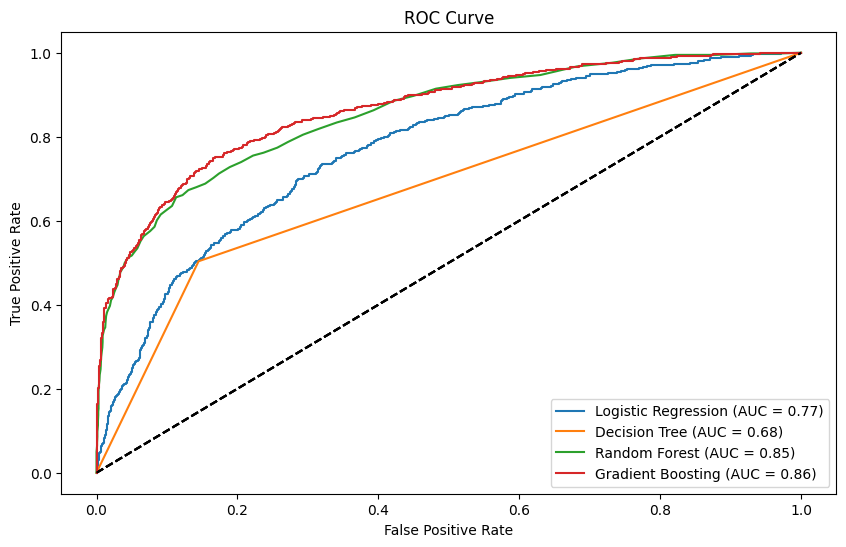

In [5]:
# Part 4.1: use ROC curve to demonstrate the best model

# ROC Curve
def plot_roc_curve(y_test, y_pred_prob, model_name):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:,1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

plt.figure(figsize=(10, 6))
plot_roc_curve(y_test, log_reg.predict_proba(X_test_scaled), 'Logistic Regression')
plot_roc_curve(y_test, tree_clf.predict_proba(X_test), 'Decision Tree')
plot_roc_curve(y_test, rf_clf.predict_proba(X_test), 'Random Forest')
plot_roc_curve(y_test, gb_clf.predict_proba(X_test), 'Gradient Boosting')
plt.show()

/var/folders/0h/0f26ts797zn_y1qfqv62wxg40000gn/T/ipykernel_17348/2422554009.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(value, index, f'{coef_importance_sorted[index]:.2f}', va='center', ha='right', color='black')


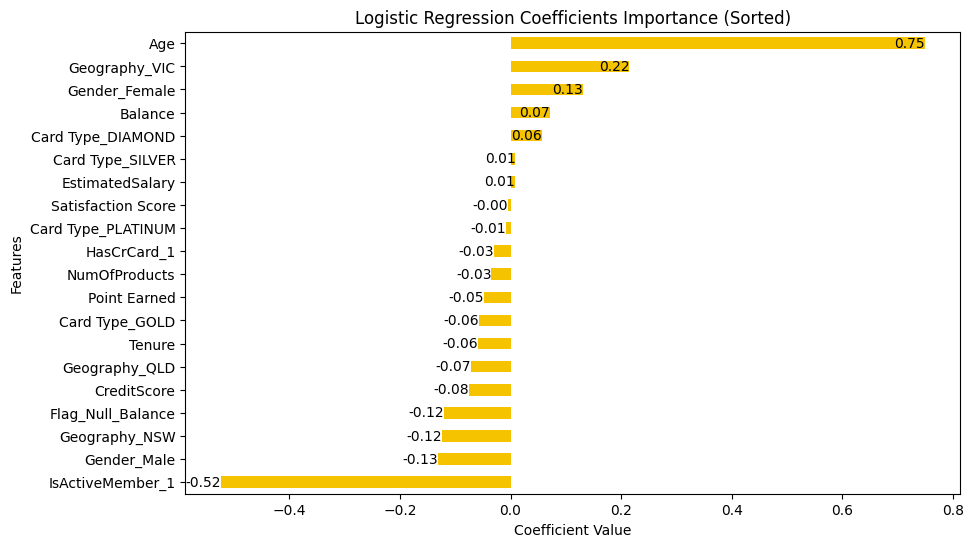

In [6]:
# Part 5.1: understanding key drivers, using logistic regression 

# Logistic Regression Coefficients
# coef_importance = pd.Series(log_reg.coef_[0], index=X.columns)
# coef_importance = coef_importance.abs().sort_values(ascending=False)
# print("\nLogistic Regression Coefficient Importance:")
# print(coef_importance)


# Plot Logistic Regression Coefficients (Sorted by importance)
coef_importance = pd.Series(log_reg.coef_[0], index=X.columns)
coef_importance_sorted = coef_importance.sort_values(ascending=False)  # Sorting by absolute values

plt.figure(figsize=(10,6))
coef_importance_sorted.plot(kind='barh', color='#F5C300')

# Annotate each bar with the actual coefficient value
for index, value in enumerate(coef_importance_sorted):
    plt.text(value, index, f'{coef_importance_sorted[index]:.2f}', va='center', ha='right', color='black')
    
plt.title('Logistic Regression Coefficients Importance (Sorted)')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.show()



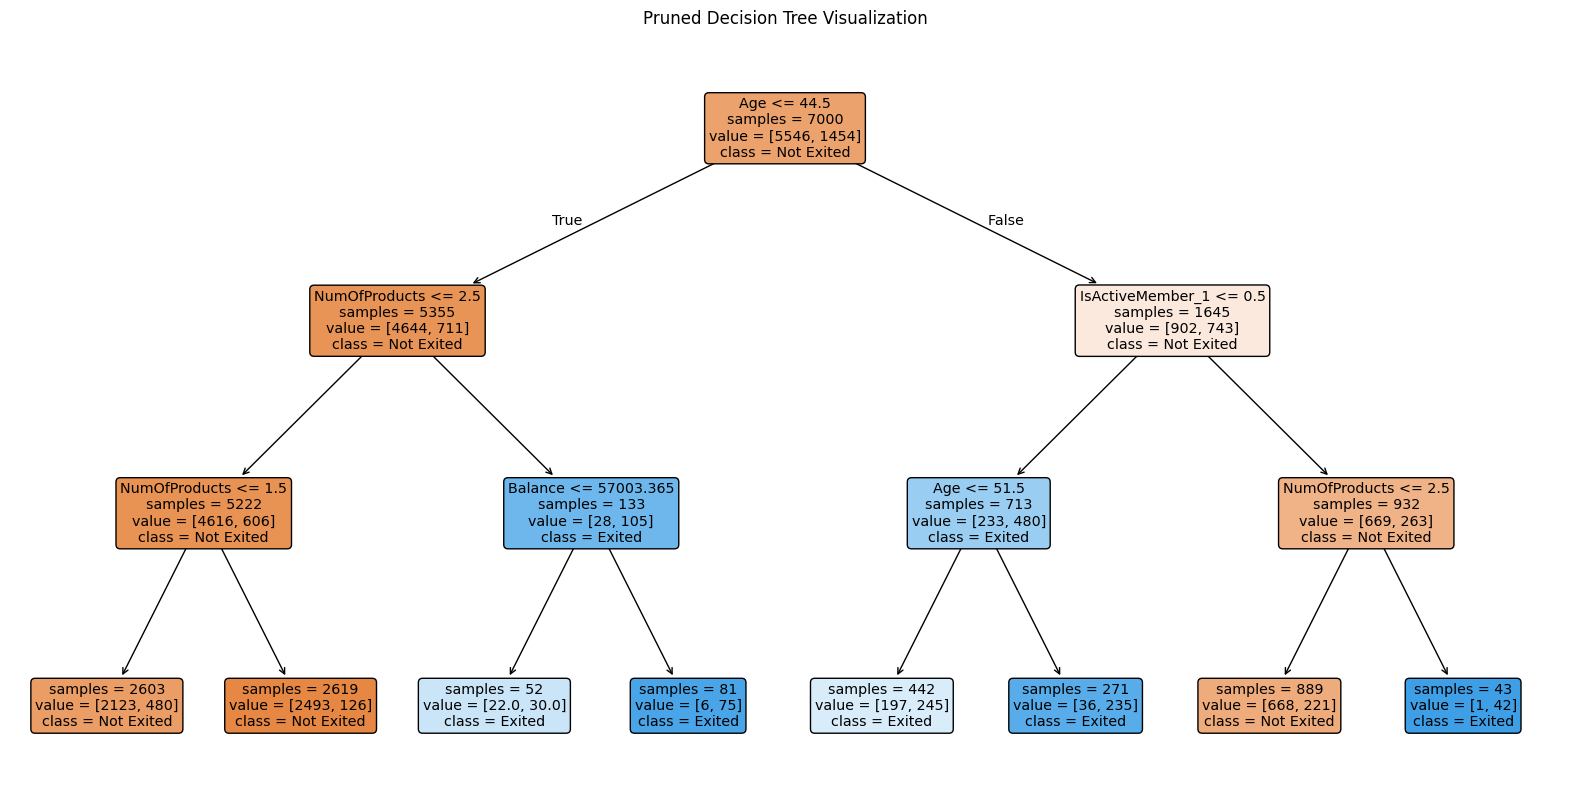


Decision Tree Feature Importance (Sorted):
Age                   0.208152
Balance               0.121349
NumOfProducts         0.118194
Point Earned          0.108671
CreditScore           0.101870
EstimatedSalary       0.090590
IsActiveMember_1      0.063649
Tenure                0.050947
Satisfaction Score    0.035186
Geography_VIC         0.020113
Card Type_GOLD        0.012568
Card Type_DIAMOND     0.012022
Gender_Male           0.011867
HasCrCard_1           0.010581
Card Type_PLATINUM    0.008071
Card Type_SILVER      0.006440
Geography_NSW         0.006273
Geography_QLD         0.006201
Gender_Female         0.005666
Flag_Null_Balance     0.001589
dtype: float64


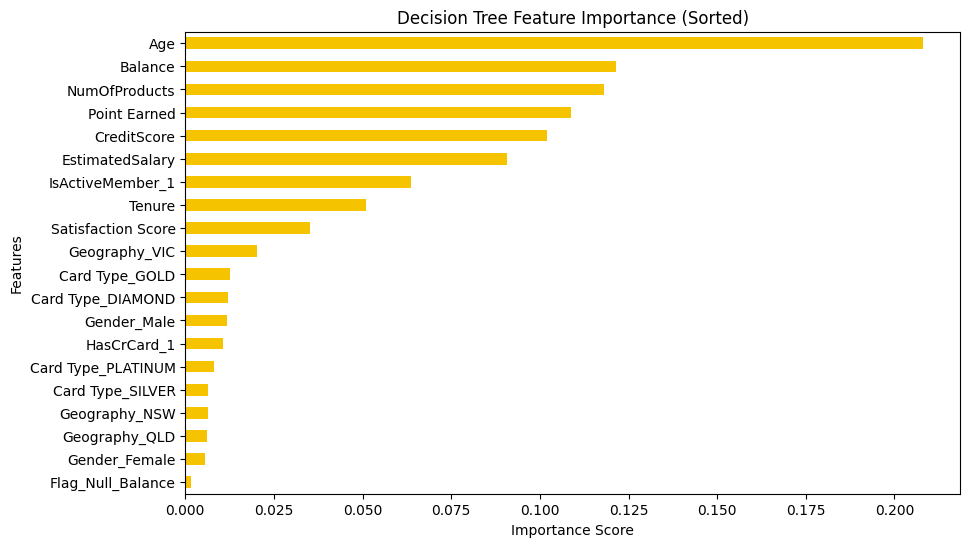

In [7]:
# Part 5.2: understanding key drivers, using decision tree

# Set a max_depth to prune the tree and avoid overfitting
# You can adjust the max_depth based on your preferences
pruned_tree_clf = DecisionTreeClassifier(random_state=42, max_depth=3)  # Limit the tree depth
pruned_tree_clf.fit(X_train, y_train)


# Plot the pruned Decision Tree
plt.figure(figsize=(20,10))

plot_tree(pruned_tree_clf, 
          feature_names=X.columns, 
          filled=True, 
          rounded=True, 
          class_names=['Not Exited', 'Exited'],
          proportion=False, 
          impurity=False,
          node_ids=False
          )

plt.title("Pruned Decision Tree Visualization")
plt.show()


# Feature Importance from Decision Tree
tree_importance = pd.Series(tree_clf.feature_importances_, index=X.columns)
tree_importance_sorted = tree_importance.sort_values(ascending=False)

# Print the feature importance
print("\nDecision Tree Feature Importance (Sorted):")
print(tree_importance_sorted)

# Plot Decision Tree Feature Importance
plt.figure(figsize=(10,6))
tree_importance_sorted.plot(kind='barh', color='#F5C300')
plt.title('Decision Tree Feature Importance (Sorted)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.show()


In [ ]:
# Part 6: Hyperparameter Tuning


# Hyperparameter Tuning for the Best Model (Assuming Random Forest had the highest accuracy)
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2)
grid_search.fit(X_train, y_train)

# Best Hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Evaluate Best Model on Test Data
best_rf_clf = grid_search.best_estimator_
y_pred_best_rf = best_rf_clf.predict(X_test)

evaluate_model(y_test, y_pred_best_rf, "Tuned Random Forest")


In [ ]:
# part 6.2, hyperparameter tuning from lecture notes

# Random forest hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a Random Forest Classifier with the parameter grid
rf_clf = RandomForestClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=3)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params_rf = grid_search.best_params_

print(f'Best parameters for Random Forest: {best_params_rf}')

# Train the model with best parameters
best_grid = grid_search.best_estimator_
best_grid.fit(X_train, y_train)

# Predict the response for the test dataset
y_pred = best_grid.predict(X_test)

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print evaluation metrics
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1 score:", metrics.f1_score(y_test, y_pred))


In [ ]:
# 6.3, tune GBM as its the best performing model

# Random forest hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1],
       'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a GBM Classifier with the parameter grid
gbm_clf = GradientBoostingClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=gbm_clf, param_grid=param_grid, cv=3)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params_gbm = grid_search.best_params_

print(f'Best parameters for GBM: {best_params_gbm}')

# Train the model with best parameters
best_grid = grid_search.best_estimator_
best_grid.fit(X_train, y_train)

# Predict the response for the test dataset
y_pred = best_grid.predict(X_test)

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print evaluation metrics
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1 score:", metrics.f1_score(y_test, y_pred))
